In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path

import geopandas as gpd

from openelec import clustering

## Create clusters

In [15]:
def prepare_clusters(country):
    folder_input = Path.home() / 'Documents/GIS'
    ghs_in = folder_input / 'GHS_POP_250.tif'
    gdp_in = folder_input / 'GDP.tif'
    travel_in = folder_input / 'Travel.tif'
    ntl_in = folder_input / 'VIIRS_Africa_2016.tif'
    clip_boundary = folder_input / 'gadm_global.gpkg'
    grid_in = '/home/chris/Work/Tanzania/Data/tz_grid.gpkg'
    
    folder_output = Path.home() / 'Documents/Code/openelec_app/openelec_app/static/{country.lower()}'
    clusters_out = folder_output / 'clusters.geojson'
    
    print('Clipping raster...', end='', flush=True)
    boundary = gpd.read_file(clip_boundary)
    boundary = boundary.loc[boundary['NAME_0'] == country]
    clipped, affine, crs = clustering.clip_raster(raster=ghs_in, boundary=boundary)
    
    print('\t\tDone\nCreating clusters...', end='', flush=True)
    clusters = clustering.create_clusters(raster=clipped, affine=affine, crs=crs)
    
    print('\t\tDone\nFiltering and merging...', end='', flush=True)
    # Increase buffer to 500m?
    clusters = clustering.filter_merge_clusters(clusters=clusters, buffer_amount=500)
    
    print('\tDone\nGetting population...', end='', flush=True)
    # Number of people per cluster
    clusters = clustering.add_raster_layer(clusters=clusters, raster=ghs_in, operation='sum', col_name='pop')
    
    print('\tDone\nGetting NTL...', end='', flush=True)
    # Value from -0.1ish to about 30? We cut off negative values to minimum 0
    clusters = clustering.add_raster_layer(clusters=clusters, raster=ntl_in, operation='max', col_name='ntl', crs={'init': 'epsg:4326'})
    clusters = clustering.fix_column(clusters, 'ntl', minimum=0)
    
    print('\tDone\nGetting travel...', end='', flush=True)
    # Travel time to cities, divide by 60m to get hours and replace nan with median
    clusters = clustering.add_raster_layer(clusters=clusters, raster=travel_in, operation='median', col_name='travel')
    clusters = clustering.fix_column(clusters, 'travel', factor=1/60, no_value='median')
    
    print('\tDone\nGetting GDP...', end='', flush=True)
    # Get GDP in USD/capita for each cluster (input is kUSD per cell)
    clusters = clustering.add_raster_layer(clusters=clusters, raster=gdp_in, operation='sum', col_name='gdp')
    clusters = clustering.fix_column(clusters, 'gdp', factor=1000, maximum='largest', no_value='median', per_capita=True)
    
    print('\t\tDone\nGetting grid dists...', end='', flush=True)
    # Get grid distance in km
    grid = gpd.read_file(grid_in)
    grid = grid[grid.geometry.intersects(boundary.geometry.unary_union)]
    clusters = clustering.add_vector_layer(clusters=clusters, vector=grid, operation='distance', col_name='grid',
                                                shape=clipped[0].shape, affine=affine, raster_crs=crs)
    clusters = clustering.fix_column(clusters, 'grid', factor=1/1000)
    
    print('\t\tDone\nSimplifying geometry...', end='', flush=True)
    clusters.geometry = clusters.simplify(tolerance=0.001, preserve_topology=False)
    
    print(f'\t\tDone\nSaving to {str(clusters_out)}...', end='', flush=True)
    clusters['fid'] = clusters.index
    clustering.save_clusters(clusters=clusters, out_path=clusters_out)
    
    print('\t\tDone')
    
    return clusters

In [10]:
clusters = prepare_clusters('Tanzania')

Clipping raster...		Done
Creating clusters...		Done
Filtering and merging...	Done
Getting population...	Done
Getting NTL...	Done
Getting travel...	Done
Getting GDP...		Done
Getting grid dists...		Done
Simplifying geometry...		Done
Saving to /home/chris/Documents/Code/openelec_app/openelec_app/static/{country.lower()}/clusters.geojson...		Done


## Read NTL

In [ ]:
country = 'Lesotho'
folder_input = Path('/home/chris/Documents/GIS')
ghs_in = folder_input / 'GHS_POP_250.tif'
gdp_in = folder_input / 'GDP.tif'
travel_in = folder_input / 'Travel.tif'
ntl_in = folder_input / 'NTL_C2.tif'

clip_boundary = folder_input / 'gadm_global.gpkg'
grid_in = folder_input / 'africagrid.gpkg'
clusters_file = folder_input / f'clusters_{country}_2.gpkg'

In [ ]:
ntl = rasterio.open(ntl_in, mode='r')
ghs = rasterio.open(ghs_in, crs=4326)

In [ ]:
rasterio.open(ntl_in, mode='r').crs

In [ ]:
plt.imshow(ntl.read(1), cmap='pink')

In [ ]:
boundary = gpd.read_file(clip_boundary)
boundary = boundary.loc[boundary['NAME_0'] == country]
clipped, affine, crs = clustering.clip_raster(raster=ghs_in, boundary=boundary)
clusters = clustering.create_clusters(raster=clipped, affine=affine, crs=crs)
clusters = clustering.filter_merge_clusters(clusters=clusters, buffer_amount=250)

In [ ]:
boundary = boundary.to_crs(epsg=4326)
coords = [json.loads(boundary.to_json())['features'][0]['geometry']]

In [ ]:
raster = rasterio.open(ntl_in, crs=4326)
clipped, affine = mask(dataset=raster, shapes=coords, crop=True)
clipped = clipped[0]

In [ ]:
new_dataset = rasterio.open('/home/chris/Documents/GIS/clipped.tif', 'w', driver='GTiff',
                              height=clipped.shape[0], width=clipped.shape[1],
                                 count=1, dtype=clipped.dtype,
                              crs='+proj=latlong', transform=affine)
new_dataset.write(clipped, 1)
new_dataset.close()

In [ ]:
show(clipped[2], transform=affine)

In [ ]:
stats = zonal_stats(clusters, '/home/chris/Documents/GIS/clipped.tif', stats='mean')
stats

## Clusterize HRSL

In [ ]:
import json
from pathlib import Path

import numpy as np
from scipy import ndimage
import geopandas as gpd

import rasterio
from rasterio.mask import mask
from rasterio.features import shapes, rasterize
from rasterstats import zonal_stats

In [ ]:
folder_input = Path('/home/chris/Documents/GIS')
hrsl_in = folder_input / 'HRSL_RWA' / 'hrsl_rwa_pop.tif'
hrsl = rasterio.open(hrsl_in)

In [ ]:
plt.imshow(hrsl.read(1), cmap='pink')

In [ ]:
hrsl.read(1).dtype

# Simplify

In [76]:
gis_path= Path.home() / 'Documents/Code/openelec_app/openelec_app/static/rwanda/clusters.geojson'

gdf = gpd.read_file(gis_path)
gdf.head()

,area,pop,ntl,travel,gdp,grid,geometry
0,3.368466e+07,84626.523438,15.958363,1.800000,241.969056,0.000000,POLYGON ((29.75499344031981 -2.652883664447353...
1,4.418296e+07,115147.625000,3.782737,5.741667,219.700580,0.000000,POLYGON ((29.00321538957977 -2.707224869274936...
2,7.499433e+06,13829.521484,0.142395,2.083333,43.240831,3.691206,"POLYGON ((29.57332635624572 -2.51736217036512,..."
3,6.599887e+06,4717.690430,0.058999,3.700000,141.594708,0.000000,POLYGON ((29.71326951845277 -2.529498199156309...
4,4.961723e+06,6892.660645,0.209824,2.066667,41.058165,0.000000,"POLYGON ((29.625402149435 -2.493090242465807, ..."


In [77]:
gdf['fid'] = gdf.index
gdf.head()

,area,pop,ntl,travel,gdp,grid,geometry,fid
0,3.368466e+07,84626.523438,15.958363,1.800000,241.969056,0.000000,POLYGON ((29.75499344031981 -2.652883664447353...,0
1,4.418296e+07,115147.625000,3.782737,5.741667,219.700580,0.000000,POLYGON ((29.00321538957977 -2.707224869274936...,1
2,7.499433e+06,13829.521484,0.142395,2.083333,43.240831,3.691206,"POLYGON ((29.57332635624572 -2.51736217036512,...",2
3,6.599887e+06,4717.690430,0.058999,3.700000,141.594708,0.000000,POLYGON ((29.71326951845277 -2.529498199156309...,3
4,4.961723e+06,6892.660645,0.209824,2.066667,41.058165,0.000000,"POLYGON ((29.625402149435 -2.493090242465807, ...",4


In [78]:
gdf.to_file(gis_path, driver='GeoJSON')

/home/chris/anaconda3/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
CPLE_NotSupported in driver GeoJSON does not support creation option ENCODING
CPLE_NotSupported in dataset /home/chris/Documents/Code/openelec_app/openelec_app/static/rwanda/clusters.geojson does not support layer creation option ENCODING
CPLE_NotSupported in dataset /home/chris/Documents/Code/openelec_app/openelec_app/static/rwanda/clusters.geojson does not support layer creation option ENCODING


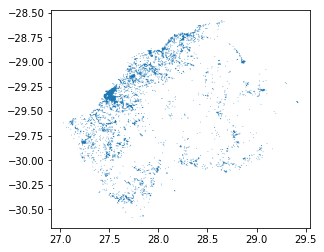

In [39]:
tol = gdf.copy()
tol.geometry = gdf.simplify(tolerance=0.001, preserve_topology=False)
tol.plot()

In [43]:
tol.head()

,area,pop,ntl,travel,gdp,grid,geometry
0,3.664338e+06,3760.354492,0.817591,2.458333,237.743543,5.031153,POLYGON ((27.62832800728892 -30.39640964697279...
1,9.529667e+06,14935.695312,0.919827,2.858333,30.062209,0.000000,"POLYGON ((27.6656664758091 -30.36004951741453,..."
2,4.055593e+06,4339.094727,0.016206,3.958333,13.827769,54.028349,POLYGON ((28.37937547016989 -30.01167819205005...
3,3.397839e+06,6862.478027,0.041586,3.050000,22.586593,3.889087,POLYGON ((27.23327524438427 -29.97537173335694...
4,2.109558e+06,614.652039,0.440330,1.966667,543.396880,4.506939,POLYGON ((27.49861920190072 -29.82165874282862...


In [44]:
file_out_tol = gis_path / 'tol.gpkg'
tol.to_file(file_out_tol, driver='GPKG')

/home/chris/anaconda3/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
CPLE_NotSupported in dataset /home/chris/Documents/GIS/tol.gpkg does not support layer creation option ENCODING
CPLE_NotSupported in dataset /home/chris/Documents/GIS/tol.gpkg does not support layer creation option ENCODING


0    POLYGON ((27.62323683398616 -30.39854863745852...
1    POLYGON ((27.68102203751268 -30.40068764565941...
2    POLYGON ((28.38286250785172 -30.01594987049625...
3    POLYGON ((27.22891429225209 -29.98177839053503...
4    POLYGON ((27.49353652813961 -29.82379303190549...
dtype: object

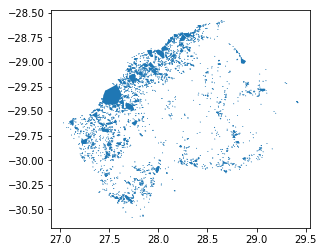

In [36]:
hulls = gdf.convex_hull
hulls.plot(ax=gdf.plot())
hulls.head()

In [37]:
file_hull = gis_path / 'hull.gpkg'
hulls.to_file(file_hull, driver='GPKG')

/home/chris/anaconda3/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
CPLE_NotSupported in driver GPKG does not support creation option ENCODING
CPLE_NotSupported in dataset /home/chris/Documents/GIS/hull.gpkg does not support layer creation option ENCODING
CPLE_NotSupported in dataset /home/chris/Documents/GIS/hull.gpkg does not support layer creation option ENCODING


In [45]:
json_file = gis_path / 'jsontest.geojson'
tol.to_file(json_file, driver='GeoJSON')

/home/chris/anaconda3/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
CPLE_NotSupported in driver GeoJSON does not support creation option ENCODING
CPLE_NotSupported in dataset /home/chris/Documents/GIS/jsontest.geojson does not support layer creation option ENCODING
CPLE_NotSupported in dataset /home/chris/Documents/GIS/jsontest.geojson does not support layer creation option ENCODING


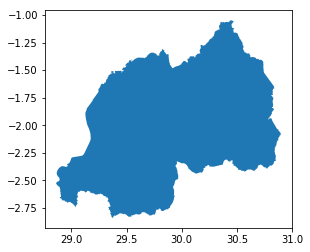

In [65]:
admin_file = Path.home() / 'Documents/Code/openelec_app/openelec_app/static/rwanda/admin.geojson'
admin = gpd.read_file(admin_file)
admin.plot()

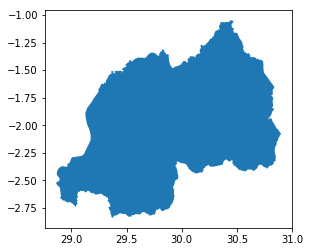

In [66]:
admin.geometry = admin.simplify(tolerance=0.001, preserve_topology=False)
admin.plot()

In [67]:
admin.head()

,fid,NAME_0,geometry
0,74,Rwanda,"(POLYGON ((29.12520981 -2.60767221, 29.123909 ..."


In [68]:
admin.to_file(Path.home() / 'Downloads/admin.geojson', driver='GeoJSON')

/home/chris/anaconda3/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
CPLE_NotSupported in driver GeoJSON does not support creation option ENCODING
CPLE_NotSupported in dataset /home/chris/Downloads/admin.geojson does not support layer creation option ENCODING
CPLE_NotSupported in dataset /home/chris/Downloads/admin.geojson does not support layer creation option ENCODING


# Simplify grid

In [3]:
grid_in = Path.home() / 'Downloads/grid.geojson'
grid = gpd.read_file(grid_in)
grid.head()

,geometry
0,"(LINESTRING (38.2172771 -4.8873877, 38.2197185..."
1,"(LINESTRING (38.2246319 -4.9038052, 38.2255428..."
2,"(LINESTRING (38.1904102 -4.8419189, 38.193092 ..."
3,"(LINESTRING (38.3208914 -6.5701642, 38.3344569..."
4,"(LINESTRING (38.7438104 -6.711318, 38.7420706 ..."


In [10]:
grid['length'] = grid.length
grid = grid.loc[grid['length'] > 0.01]

In [21]:
grid = grid.loc[grid.geometry.type != 'MultiLineString']

In [22]:
grid.loc[grid.geometry.type == 'MultiLineString']

Series([], dtype: object)

In [12]:
grid = grid.simplify(tolerance=0.001, preserve_topology=False)

In [23]:
grid_out = Path.home() / 'Downloads/grid5.geojson'
grid.to_file(grid_out, driver='GeoJSON')

/home/chris/anaconda3/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
CPLE_NotSupported in driver GeoJSON does not support creation option ENCODING
CPLE_NotSupported in dataset /home/chris/Downloads/grid5.geojson does not support layer creation option ENCODING
CPLE_NotSupported in dataset /home/chris/Downloads/grid5.geojson does not support layer creation option ENCODING


# Check cluster size

In [29]:
c_in = Path.home() / 'Documents/Code/openelec_app/openelec_app/static/rwanda/clusters.geojson'
c = gpd.read_file(c_in)
c.head()

,area,pop,ntl,travel,gdp,grid,fid,geometry
0,3.368466e+07,84626.523438,15.958363,1.800000,241.969056,0.000000,0,POLYGON ((29.75499344031981 -2.652883664447353...
1,4.418296e+07,115147.625000,3.782737,5.741667,219.700580,0.000000,1,POLYGON ((29.00321538957977 -2.707224869274936...
2,7.499433e+06,13829.521484,0.142395,2.083333,43.240831,3.691206,2,"POLYGON ((29.57332635624572 -2.51736217036512,..."
3,6.599887e+06,4717.690430,0.058999,3.700000,141.594708,0.000000,3,POLYGON ((29.71326951845277 -2.529498199156309...
4,4.961723e+06,6892.660645,0.209824,2.066667,41.058165,0.000000,4,"POLYGON ((29.625402149435 -2.493090242465807, ..."


In [28]:
print('Tanzania')
len(c)

Tanzania


8034

In [30]:
print('Rwanda')
len(c)

Rwanda


2864